## Empirical IO - Probem Set 1
Eyal, Jimena and Pietro

## Data Cleaning
Before we start estimation, we need to manipulate data a bit so that we have the incomes at the bottom, middle and top of the bins. We also need to deal with the different categorization for year 2010 and on. The last thing we need to do before we start estimation is to manipulate the projection factors so that we get weights that add up to one. We do all of that setup in this section.

In [322]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
import matplotlib as plt

#Data = pd.read_csv('simulated_income_data.csv', index_col=0) 

Data = pd.read_csv('https://raw.githubusercontent.com/pietroreggiani/Grad-IO/master/Assignments/Assignment%201-MLE%20and%20GMM/simulated_income_data.csv', index_col=0)

In [323]:
Data

,panel_year,household_income,projection_factor
0,2007,3,3086
1,2007,4,3451
2,2007,6,7203
3,2007,8,9264
4,2007,10,7331
...,...,...,...
116,2013,19,15934
117,2013,21,32978
118,2013,23,26666
119,2013,26,89884


In [324]:
### the codes for the tops of the inccome bins are given by top (except for the last bien which is not bounded):
### we will need to deal with the year 2010 onwards in a different way since the top bracket changes

incomes = pd.DataFrame( np.array([[3, 4999], [4, 7999], [6, 9999], [8, 11999], [10, 14999], [11, 19999], [13, 24999], \
                              [15, 29999], [16, 35999], [17, 39999], [18, 44999], [19, 49999], [21, 59999], [23, 69999], \
                              [26, 99999], [27, 124999], [28, 149999], [29, 199999], [30, 10**6]  ])     ,   columns = ['household_income' , 'top_income']   )

### for the bottoms of the bins we have an extra bin (now the top bin has a value and we assign zero to the first bin):
incomes['bottom_income'] = np.append( 0.5, np.array( incomes['top_income'][0:-1]+1   ) )   
incomes['mid_income'] = (incomes['bottom_income']+incomes['top_income'] ) /2

print(incomes)

### for the mid points we just use the bottom and top form above:
### again we will have to deal with year 2010 onwards in a different way but we worry about that later


    household_income  top_income  bottom_income  mid_income
0                  3        4999            0.5     2499.75
1                  4        7999         5000.0     6499.50
2                  6        9999         8000.0     8999.50
3                  8       11999        10000.0    10999.50
4                 10       14999        12000.0    13499.50
5                 11       19999        15000.0    17499.50
6                 13       24999        20000.0    22499.50
7                 15       29999        25000.0    27499.50
8                 16       35999        30000.0    32999.50
9                 17       39999        36000.0    37999.50
10                18       44999        40000.0    42499.50
11                19       49999        45000.0    47499.50
12                21       59999        50000.0    54999.50
13                23       69999        60000.0    64999.50
14                26       99999        70000.0    84999.50
15                27      124999       1

In [325]:
## we get the average projection factor for each of the last bins (up to and including 2009) so that we can use it to fill in the missing bins for the years 2010 onwards
last_bins = Data.loc[(Data['panel_year']<=2009) & (Data['household_income']>=27)]  

factors = np.array([np.mean(last_bins[last_bins['household_income']==i]['projection_factor']) for i in range(27,31)])

rel_factor = factors/np.sum(factors)


In [326]:
## for the years where we don't have the last bins we use the relative factors computed above
missing_bins = Data[Data['panel_year']>=2010]
Bin27 = missing_bins[missing_bins['household_income']==27]['projection_factor']
print(Bin27)
new_factors = []
for t in Bin27:
  new_factors = np.append(new_factors, t*rel_factor)


72     158363
88     167717
104    144486
120    156732
Name: projection_factor, dtype: int64


In [327]:
### We create an array with the new Rows that we want to add (for the bins that we created) and append those rows to the Data frame
vector =  np.ones(4)
years = np.array([2010*vector, 2011*vector, 2012*vector, 2013*vector])
years = years.flatten()


Bin_id = np.vstack([[27, 28, 29, 30], [27, 28, 29, 30], [27, 28, 29, 30], [27, 28, 29, 30]])
Bin_id = Bin_id.flatten()
Bin_id

Rows_matrix = np.column_stack((years, Bin_id, new_factors.flatten()))
columns = Data.columns 
Rows_DF = pd.DataFrame(Rows_matrix, columns=columns)


In [328]:
### drop the rows that we are replacing and append the new ones: all the years that have bin 27 as the last one are being replaced by the new rows with bins 27, 28 , 29 and 30
Data1=Data.drop(Bin27.index)

Data_2 = Data1.append(Rows_DF, ignore_index=True)

Data_2 #is the new data set where we spread the 27th bin into 30 bins according to proportion before 2010

,panel_year,household_income,projection_factor
0,2007.0,3.0,3086.000000
1,2007.0,4.0,3451.000000
2,2007.0,6.0,7203.000000
3,2007.0,8.0,9264.000000
4,2007.0,10.0,7331.000000
...,...,...,...
128,2012.0,30.0,12004.183713
129,2013.0,27.0,107003.771988
130,2013.0,28.0,18089.812476
131,2013.0,29.0,18616.809832


In [329]:
### now we deal with the weights that we will use to calcualte the empirical moments 
### and add them as a column to our data frame

# we need to normalize the weights within every year so that they sum to one 
# we will end up with the fraction of people in each income bracket every year
Data_2['yearly_sum'] = Data_2['projection_factor'].groupby(Data_2['panel_year']).transform('sum')

Data_2['yearly_weights'] = Data_2['projection_factor'] / Data_2['yearly_sum']

# the yearly weights sum to one every year ----> GREAT


## Join to data the income vectors we created above for bottom middle and top.
table =  pd.merge(Data_2, incomes  , on='household_income', how ='left')

table = table.sort_values(['panel_year', 'household_income'])
table

,panel_year,household_income,projection_factor,yearly_sum,yearly_weights,top_income,bottom_income,mid_income
0,2007.0,3.0,3086.000000,501337.0,0.006156,4999,0.5,2499.75
1,2007.0,4.0,3451.000000,501337.0,0.006884,7999,5000.0,6499.50
2,2007.0,6.0,7203.000000,501337.0,0.014368,9999,8000.0,8999.50
3,2007.0,8.0,9264.000000,501337.0,0.018479,11999,10000.0,10999.50
4,2007.0,10.0,7331.000000,501337.0,0.014623,14999,12000.0,13499.50
...,...,...,...,...,...,...,...,...
116,2013.0,26.0,89884.000000,496189.0,0.181149,99999,70000.0,84999.50
129,2013.0,27.0,107003.771988,496189.0,0.215651,124999,100000.0,112499.50
130,2013.0,28.0,18089.812476,496189.0,0.036458,149999,125000.0,137499.50
131,2013.0,29.0,18616.809832,496189.0,0.037520,199999,150000.0,174999.50


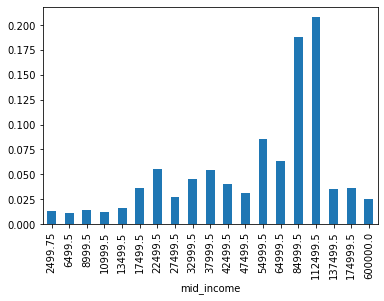

In [330]:
## Plot the distribution
empirical_dist =  table.groupby('mid_income').mean() 

empirical_dist = empirical_dist['yearly_weights']

import matplotlib.pyplot as plt
plt = empirical_dist.plot(kind='bar',x='mid_income',y ='yearly_weights')
plt

## Part 1: Method of Moments

First we assume that the distribution of income is lognormal. 

 We want to compute, by MM, the estimator of the parameters. Then we take $\log y_i$ and estimate the parameters of a normal distribution.

In [331]:
# define a function that takes the correct column and returns average and variance
def howImetmom(table, col_name , log = 0 ):

  fun = lambda x: (np.log(x) if log ==1 else x)

  num_years = np.size( table['panel_year'].unique() )

  mean =  (  np.dot(  np.array( table['projection_factor']) , fun( np.array(table[col_name] ) ) )   ).sum() /  np.array(table['projection_factor'].sum())

  var   =    (  (( fun( table[col_name] ) - mean )**2).dot(np.array(table['projection_factor'])) ).sum()  / np.array(table['projection_factor'].sum())

  
  if log == 0:
    sigma = np.sqrt( np.log(     (   var / np.exp(2* np.log(mean)  )      ) +1     )      )
    mu = np.log(mean) - 0.5 * sigma **2
  else:
    mu = mean
    sigma = np.sqrt(var)  

  return mu, sigma

def lognormal_convert(x):
  mu = x[0]
  sigma = x[1]
  mean = np.exp(mu + sigma**2 /2 )
  sd =  np.sqrt(( np.exp(sigma**2) -1 )*np.exp(2*mu + sigma**2))
  return mean, sd

In [332]:
mm_estimates = []
for assumption in ['bottom_income', 'mid_income' , 'top_income']:
  estimates = howImetmom(table, assumption    , log=1)
  
  mm_estimates.append( lognormal_convert(estimates)  )

print(mm_estimates)

[(145647.7167617844, 440880.44368137774), (87375.66048075157, 94863.43417129105), (99801.39410080369, 109933.00524798769)]


The estimated mean income is around \$100k and makes sense. The standard deviations however are wild.

## Part 2: Maximum likelihood

Write the likelihood for the entire sample.

$$
f(sample |\mu, \sigma) = \Pi_{i=1}^{ n } \left(  \frac{1}{\sigma \sqrt{2\pi}} exp(-0.5 *(   \frac{ln(y_i)- \mu}{\sigma}  )^2) \right)^{{proj\_factor}_{i}}
$$

now taking the log we get:
$$
ln(f(sample |\mu, \sigma))  = constant - \frac{1}{2}\sum_{i=1}^{n} proj\_factor_i (   \frac{ln(y_i)- \mu}{\sigma}  )^2 
$$

The score of this is the gradient with respect to the parameters.
The derivative with respect to $\mu$ is 
$$ \frac{\partial l}{\partial \mu} = \sum_{i=1}^{n} proj\_factor_i ( \frac{ln(y_i)- \mu}{\sigma ^2}    )
$$
while the one wrt to sigma is:

$$
\frac{\partial l}{\partial \sigma} = \sum_{i=1}^{n} proj\_factor_i ( \frac{(ln(y_i)- \mu)^2}{\sigma ^3}    )
$$

In [333]:
## write down the log likelihood function

def log_lik( theta, data, col_name):

  mu = theta[0]
  sigma = theta[1]

  log_likelihood =    np.dot( np.array( data['projection_factor']) ,     ( (  np.log(np.array(data[col_name])) - mu   ) / sigma )**2  ).sum()

  return log_likelihood

In [334]:
# write the Jacobian
def jacob(theta, data, col_name):

  mu = theta[0]
  sigma = theta[1]
    
  deriv_mu =  -2 *  np.dot( np.array( data['projection_factor']) ,     ( (  np.log(np.array(data[col_name])) - mu   ) / sigma**2 )  ).sum()

  deriv_sigma  = -2 *   np.dot( np.array( data['projection_factor']) ,     ( (  np.log(np.array(data[col_name])) - mu   )**2 / sigma**3 )  ).sum()

  return np.array([deriv_mu, deriv_sigma])


In [335]:
# now we need to find the MLE by optimizing the function

mle = []
for assumption in ['bottom_income', 'mid_income' , 'top_income']:
  output = minimize(  log_lik , np.array([ 8 , 500 ]) , args = ( table , assumption)  , jac = jacob  , method= 'Newton-CG' , options = {'maxiter' : 2000}   )   
  mle.append(output.x)

print( 'The estimates for the log income are \n'  ,   mle)



The estimates for the log income are 
 [array([  10.72933424, 7787.33464334]), array([  10.98867487, 5649.05655343]), array([  11.11374864, 5777.74756113])]


We have the point estimates, now we need to compute the standard errors.

For that we need to compute analytically the second derivative of the log-likelihood.

$$ \frac{\partial^2 l}{\partial \mu^2} = - \sum_{i=1}^{n} proj\_factor_i ( \frac{1}{\sigma ^2}    )
$$

$$ \frac{\partial^2 l}{\partial \mu \partial \sigma} = - 2 \sum_{i=1}^{n} proj\_factor_i ( \frac{ ln(y_i) - \mu}{\sigma ^3}    )
$$

$$ \frac{\partial^2 l}{\partial \sigma^2} = - 3 \sum_{i=1}^{n} proj\_factor_i \left( \frac{ (ln(y_i) - \mu)^2}{\sigma ^4}    \right)
$$

In [336]:
# we define a function that computes the hessian matrix given some parameters
def hessian(theta, col_name):
  mu, sigma = theta
  second_mu = - (1/sigma**2) *  np.array(table['projection_factor']).sum()
  cross =       -2* (1/sigma**3)  *   np.inner(np.array(table['projection_factor'])  ,    ( np.log(  np.array(table[col_name])) -mu ) )
  second_sigma = -3* (1/sigma**4)  *   np.inner(np.array(table['projection_factor'])  ,    ( np.log(  np.array(table[col_name])) -mu )**2 )

  hessian = np.array( [  [second_mu, cross],[cross, second_sigma]            ]            )

  return hessian 

In [337]:
s_errors = []
assumptions = ['bottom_income', 'mid_income' , 'top_income']

for i in range(3):
  estimates = mle[i]
  info_matrix = - np.linalg.inv( hessian( estimates , assumptions[i]  ))

  s_errors.append( np.sqrt( np.diag(info_matrix)   ) )

print('These are the standard errors of the estimates \n',s_errors)

These are the standard errors of the estimates 
 [array([4.18006283e+00, 1.23419665e+04]), array([3.03228411e+00, 1.12069520e+04]), array([3.10136248e+00, 1.16065358e+04])]


## Part 3: Generalized Method of Moments

We compute one moment condition for every bin, using all the observations across all years.

### Jacobian

This is the expression for the Jacobian:

$$ 
\frac{\partial g}{\partial \mu} = - \frac{1}{ \sigma \sqrt{2 \pi} } \left(   exp(-(log(top)-\mu)^2/2\sigma^2) - exp(-(log(bottom)-\mu)^2/2\sigma^2)  \right)
$$

$$ 
\frac{\partial g}{\partial \sigma} = - \frac{1 }{ \sigma^2 \sqrt{\pi} } \left[ (log(top)-\mu)*exp(-( log(top)-\mu)^2/2\sigma^2) - (log(bottom)-\mu)*exp(-( log(bottom)-\mu)^2/2\sigma^2)  \right]
$$

In [344]:
# we write a function that computes g for every bin
from scipy.stats import lognorm

def g( theta, table  ):
  mu, sigma = theta
  dist = lognorm(mu, sigma) 

  size = np.size(np.array(   table.groupby('household_income')['top_income'].mean()  ))

  empirical_moment =  ( 1/np.array(table['projection_factor']).sum() )   *  np.array(table.groupby('household_income').sum()['projection_factor'])
  
  top_cdf    =   dist.cdf(  np.array(   table.groupby('household_income')['top_income'].mean()  )) 
  bottom_cdf =   dist.cdf(  np.array(  table.groupby('household_income')['bottom_income'].mean()   ) )

  return (top_cdf - bottom_cdf - empirical_moment).reshape(size,1)




In [345]:
# now we need a function for the objective function of GMM
def gmm_obj( theta, wmatrix, g, table):
  return   (np.transpose(g(theta, table)) @ wmatrix  @ g(theta, table)).item()   


### First-stage Estimation
At this point we can minimize the function we defined, using the identity matrix as a weighting matrix. We will minimize using the Newton algorithm, for which we need the Jacobian computed above. Remember that $$ \frac{d g'Wg}{d\theta } = 2 \nabla(g)'Wg $$ which is a 2x1 vector.

In [348]:
# we need a function that computes the Jacobian
def jacobian(theta, w, g , table ):
  mu , sigma = theta

  log_top =    np.log(  np.array(  table.groupby('household_income')['top_income'].mean()  )   )
  log_bottom = np.log(  np.array(  table.groupby('household_income')['bottom_income'].mean()  ))

  dg_dmu = - (1 / ( sigma * np.sqrt( 2 * np.pi ) )   )  * (      np.exp(    -( log_top -mu   )**2  / ( 2* sigma**2)      )      - np.exp(    -( log_bottom -mu   )**2  / (2*sigma**2)    )    )

  dg_ds = - (1 / (sigma**2 * np.sqrt( np.pi ) )   )  * ( (log_top-mu)* np.exp(    -( log_top -mu   )**2  / (2*sigma**2)      )      - (log_bottom - mu)*np.exp(   -( log_bottom -mu   )**2  / (2*sigma**2)   )  )

  derivs = np.array( [ [dg_dmu]  ,  [dg_ds] ] )

  return (2* derivs.dot(w).dot( g(theta, table) )).flatten()  
  

In [349]:
# take number of bins
size = np.size(np.array(   table.groupby('household_income')['top_income'].mean()  ))

# now minimize objective function of GMM for the first stage
w = np.eye( size )
gmm = minimize( gmm_obj , np.array([ 1 , 500 ]) , args = ( w, g, table )  , jac = jacobian , method= 'Newton-CG' , options = {'maxiter' : 2000}   )

gmm


     fun: 1.0800611413451555
     jac: array([ 1.51721471e-07, -3.98333545e-05])
 message: 'Optimization terminated successfully.'
    nfev: 2
    nhev: 0
     nit: 1
    njev: 4
  status: 0
 success: True
       x: array([  1., 500.])

The Jacobian is very small so the algorithm does not move from the starting value. We don't think the Jacobian is wrong, but cannot find out why it gives so small values. 

All our estimates make very little sense. Means look ok but the variance is huge. Even the sample variance looks huge but we struggled to figure out why.